In [1]:
from statsmodels.stats.power import TTestIndPower
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, t

## One Sample T

### Power Calc

In [10]:
def power_one_sample_ttest(effect_size, n, alpha=0.05, alternative='two-sided'):
    """
    Calculate power for a one-sample t-test.
    """
    df = n -1
    ncp = effect_size * np.sqrt(n)

    t_crit = stats.t.ppf(1 - alpha / 2, df) if alternative == 'two-sided' else stats.t.ppf(1 - alpha, df)

    if alternative == 'two-sided':
        power = 1 - stats.nct.cdf(t_crit, df, ncp) + stats.nct.cdf(-t_crit, df, ncp)
    elif alternative == 'larger':
        power = 1 - stats.nct.cdf(t_crit, df, ncp)
    elif alternative == 'smaller':
        power = stats.nct.cdf(-t_crit, df, ncp)
    else:
        raise ValueError("alternative must be 'two-sided', 'larger', or 'smaller'")
    
    return power, df


power_one_sample_ttest(effect_size=.5, n=25, alternative="two-sided")

(np.float64(0.6697077041795133), 24)

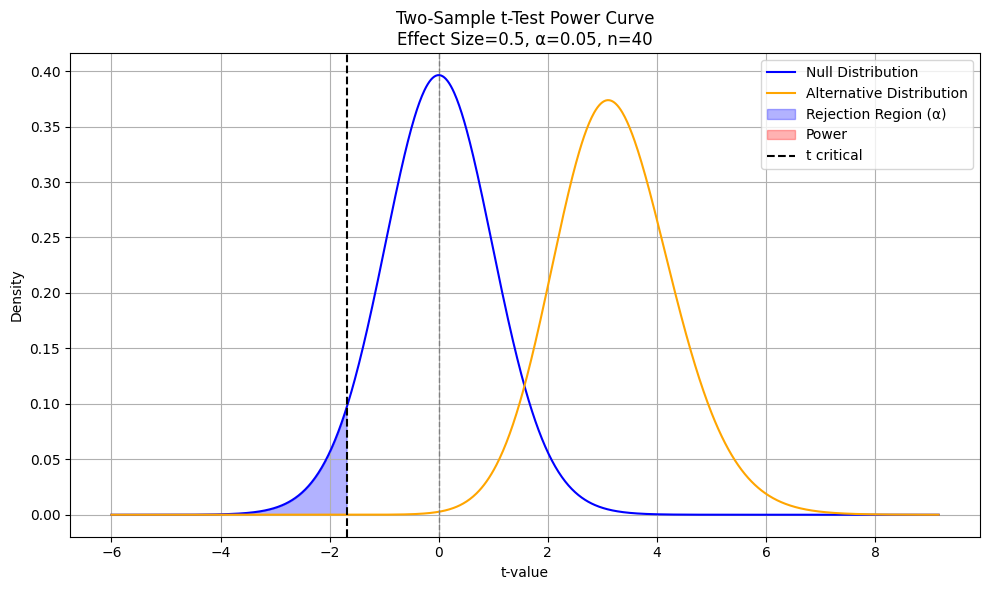

In [11]:
def plot_power_curve_with_distributions_one_sample_ttest(effect_size, n, df, alpha=0.05, alternative='two-sided', normal_approx_threshold=350):
    ncp = effect_size * np.sqrt(n)

    use_normal_approx = df > normal_approx_threshold

    # x-axis range
    x = np.linspace(-6, 6 + ncp, 1000)

    # Null distribution (central t)
    null_pdf = stats.t.pdf(x, df) if not use_normal_approx else stats.norm.pdf(x, 0, 1)

    # Alternative distribution
    alt_pdf = stats.nct.pdf(x, df, ncp) if not use_normal_approx else stats.norm.pdf(x, ncp, 1)

    # Critical values
    if alternative == 'two-sided':
        t_crit_low = stats.t.ppf(alpha / 2, df) if not use_normal_approx else stats.norm.ppf(alpha / 2)
        t_crit_high = stats.t.ppf(1 - alpha / 2, df) if not use_normal_approx else stats.norm.ppf(1 - alpha / 2)
    else:
        t_crit = stats.t.ppf(1 - alpha, df) if not use_normal_approx else stats.norm.ppf(1 - alpha)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, null_pdf, label='Null Distribution', color='blue')
    plt.plot(x, alt_pdf, label='Alternative Distribution', color='orange')

    # Shading rejection regions and power regions
    if alternative == 'two-sided':
        plt.fill_between(x, 0, null_pdf, where=(x <= t_crit_low) | (x >= t_crit_high), color='blue', alpha=0.3, label='Rejection Region (α/2)')
        plt.fill_between(x, 0, alt_pdf, where=(x <= t_crit_low) | (x >= t_crit_high), color='red', alpha=0.3, label='Power')
        plt.axvline(t_crit_low, color='black', linestyle='--', label='-t critical')
        plt.axvline(t_crit_high, color='black', linestyle='--', label='t critical')
    elif alternative == 'larger':
        plt.fill_between(x, 0, null_pdf, where=(x >= t_crit), color='blue', alpha=0.3, label='Rejection Region (α)')
        plt.fill_between(x, 0, alt_pdf, where=(x >= t_crit), color='red', alpha=0.3, label='Power')
        plt.axvline(t_crit, color='black', linestyle='--', label='t critical')
    elif alternative == 'smaller':
        plt.fill_between(x, 0, null_pdf, where=(x <= -t_crit), color='blue', alpha=0.3, label='Rejection Region (α)')
        plt.fill_between(x, 0, alt_pdf, where=(x <= -t_crit), color='red', alpha=0.3, label='Power')
        plt.axvline(-t_crit, color='black', linestyle='--', label='t critical')

    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.title(f'Two-Sample t-Test Power Curve\nEffect Size={effect_size}, α={alpha}, n={n}')
    plt.xlabel('t-value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_power_curve_with_distributions_one_sample_ttest(effect_size=0.5, n=40, df=39, alpha=0.05, alternative='smaller')

### Sample Size Calc

In [8]:
def sample_size_one_sample_ttest_equal_variance(effect_size, power_target=0.8, alpha=0.05,
                                                alternative='two-sided'):
    
    if effect_size == 0:
        raise ValueError("**WARNING:** Effect size is zero, so sample size is infinite. Enter an effect size that is not 0.")
    
    z_alpha = norm.ppf(1 - alpha / 2) if alternative == 'two-sided' else norm.ppf(1 - alpha)
    z_beta = norm.ppf(power_target)

    n = (z_alpha + z_beta) ** 2 / (effect_size ** 2)

    return np.ceil(n)

# Example usage:
n_required = sample_size_one_sample_ttest_equal_variance(effect_size=0.5, power_target=0.8, alpha=0.05, alternative="larger")
print(f"Required sample size per group: {n_required}")

Required sample size per group: 25.0


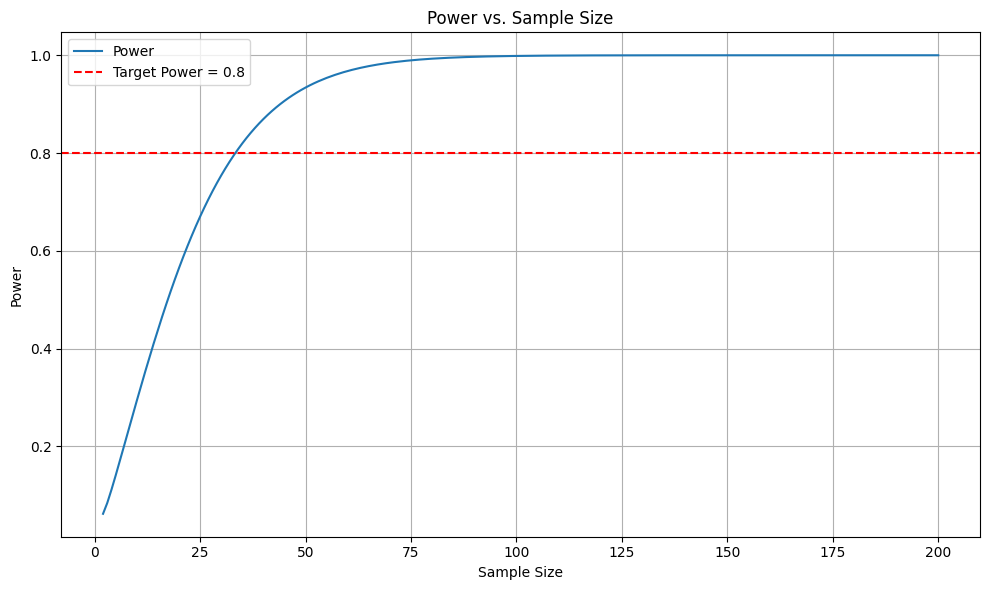

In [19]:
def plot_power_curve_one_sample_ttest(effect_size, alpha=0.05, power_target=0.8, alternative='two-sided', max_n=200):
    n_values = np.arange(2, max_n + 1)
    power_values = []

    for n in n_values:
        power, df = power_one_sample_ttest(effect_size=effect_size, n=n, alpha=alpha, alternative=alternative)
        power_values.append(power)

    plt.figure(figsize=(10, 6))
    plt.plot(n_values, power_values, label=f'Power', )
    plt.axhline(y=power_target, color='red', linestyle='--', label=f'Target Power = {power_target}')
    plt.xlabel('Sample Size')
    plt.ylabel('Power')
    plt.title('Power vs. Sample Size')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_power_curve_one_sample_ttest(effect_size=0.5, alpha=0.05, power_target=.8, alternative='two-sided', max_n=200)

### Effect Size

In [22]:
def effect_size_one_sample_ttest(n, power_target=0.8, alpha=0.05, alternative='two-sided'):
    df = n - 1

    if alternative == 'two-sided':
        t_alpha = t.ppf(1 - alpha / 2, df)
        t_beta = t.ppf(power_target, df)
    elif alternative == 'larger':
        t_alpha = t.ppf(1 - alpha, df)
        t_beta = t.ppf(power_target, df)
    else:
        t_alpha = -1 * t.ppf(1 - alpha, df)
        t_beta = -1 * t.ppf(power_target, df)

    se_term = 1 / np.sqrt(n)
    d_min = (t_alpha + t_beta) * se_term
    
    return d_min

effect_size_one_sample_ttest(50, power_target=0.8, alpha=0.05, alternative='smaller')

np.float64(-0.35716943442579485)